# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ---------------------------------------- 0.0/58.8 kB ? eta -:--:--
     ---------------------------------------- 58.8/58.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/68.5 kB ? eta -:--:--
     ---------------------------------------- 68.5/68.5 kB 3.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/106.7 kB ? eta -:--:--
   ---------------------------------------- 106.7/106.7 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.2/2.2 MB 6.7 MB/s eta 0:00:01
   -------- ------------------------------- 0.4/2.2 MB 5.4 MB/s eta 0:00:01
   ------------ --------------------------- 0.7/2.2 MB 5.5 MB/s eta 0:00:01
   ------------------ --------------------- 

  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations 'C:\Users\김주환\AppData\Local\Temp\pip-req-build-5nd8hcl8'


   ---------------------------------------- 0.0/44.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/44.8 MB 1.9 MB/s eta 0:00:24
   ---------------------------------------- 0.2/44.8 MB 2.9 MB/s eta 0:00:16
   ---------------------------------------- 0.5/44.8 MB 4.0 MB/s eta 0:00:12
    --------------------------------------- 0.7/44.8 MB 4.2 MB/s eta 0:00:11
    --------------------------------------- 1.0/44.8 MB 4.6 MB/s eta 0:00:10
   - -------------------------------------- 1.3/44.8 MB 4.9 MB/s eta 0:00:09
   - -------------------------------------- 1.6/44.8 MB 5.1 MB/s eta 0:00:09
   - -------------------------------------- 1.9/44.8 MB 5.2 MB/s eta 0:00:09
   - -------------------------------------- 2.2/44.8 MB 5.4 MB/s eta 0:00:08
   -- ------------------------------------- 2.5/44.8 MB 5.6 MB/s eta 0:00:08
   -- ------------------------------------- 2.8/44.8 MB 5.7 MB/s eta 0:00:08
   -- ------------------------------------- 3.2/44.8 MB 5.8 MB/s eta 0:00:08
   ---

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

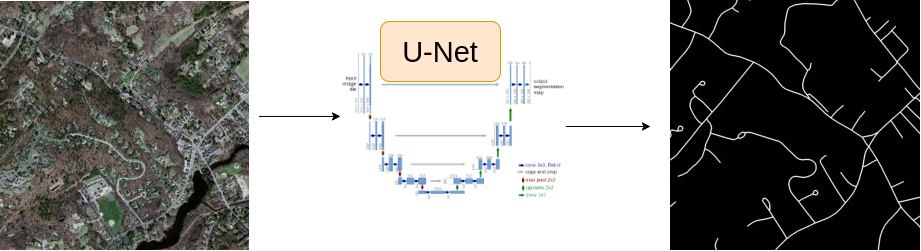

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 13.03 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [2]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [3]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

ModuleNotFoundError: No module named 'helper'

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE='cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE=8
IMG_SIZE=512

ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [6]:
df=pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [7]:
idx=15

row=df.iloc[idx]

image_path=DATA_DIR+row.images
mask_path=DATA_DIR + row.masks

image = cv2.imread(image_path)
umage=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255

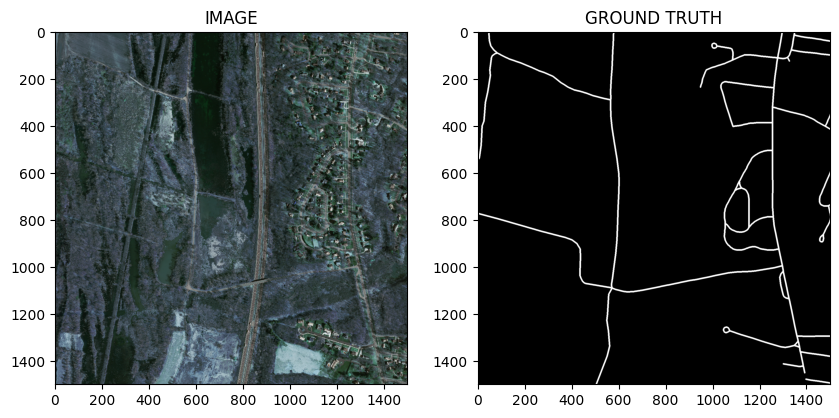

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [12]:
import albumentations as A

In [19]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [14]:
from torch.utils.data import Dataset

In [38]:
class SegmentationDataset(Dataset):

  def __init__(self,df,augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):

    row=self.df.iloc[idx]

    image_path=DATA_DIR+row.images
    mask_path=DATA_DIR + row.masks

    image = cv2.imread(image_path)
    umage=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w)
    mask = np.expand_dims(mask, axis = -1) #(h,w,c)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image'] #(h,w,c)
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32) #(c,h,w)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)  #(c,h,w)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask


In [39]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())


In [40]:
print(f'Size of trainset : {len(trainset)}')
print(f'Size of validset : {len(validset)}')

Size of trainset : 159
Size of validset : 40


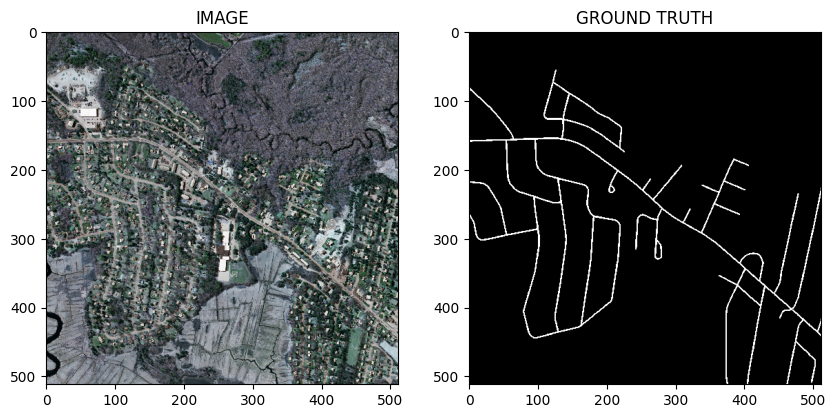

In [42]:
idx = 21

image,mask = trainset[idx]

helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [44]:
from torch.utils.data import DataLoader

In [46]:
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [48]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')

Total no. of batches in trainloader : 20
Total no. of batches in validloader : 5


In [49]:
for images, masks in trainloader:
  print(f'One batch image shape : {images.shape}')
  print(f'One batch mask shape : {masks.shape}')
  break;

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [50]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [52]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.backbone(images)

    if masks != None:
      return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

    return logits

In [53]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:02<00:00, 10.3MB/s]


SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
      

# Task 7 : Create Train and Validation Function

In [59]:
def train_fn(dataloader, model, optimizer):

  model.train() # Turn ON dropout, batcgnorm, etc..

  total_loss = 0.0

  for images, masks in tqdm(dataloader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [60]:
def eval_fn(dataloader, model):

  model.eval() # Turn OFF dropout, batcgnorm, etc..

  total_loss = 0.0

  with torch.no_grad():

    for images, masks in tqdm(dataloader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss / len(dataloader)

# Task 8 : Train Model

In [61]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [62]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "best-model.pt")
    print("SAVED.MODEL")
    best_loss = valid_loss

  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


SAVED.MODEL
Epoch : 1 Train Loss : 0.8943545892834663 Valid Loss : 1.0127149820327759


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


SAVED.MODEL
Epoch : 2 Train Loss : 0.28758814185857773 Valid Loss : 0.955801248550415


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


SAVED.MODEL
Epoch : 3 Train Loss : 0.1548107910901308 Valid Loss : 0.7731051445007324


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


SAVED.MODEL
Epoch : 4 Train Loss : 0.1103935543447733 Valid Loss : 0.7292002439498901


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 5 Train Loss : 0.10074897296726704 Valid Loss : 0.7550948262214661


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch : 6 Train Loss : 0.07713445462286472 Valid Loss : 0.7459360361099243


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 7 Train Loss : 0.05606574062258005 Valid Loss : 0.7674146890640259


100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch : 8 Train Loss : 0.04768314175307751 Valid Loss : 0.7559580206871033


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch : 9 Train Loss : 0.04154057502746582 Valid Loss : 0.7612330913543701


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch : 10 Train Loss : 0.03260611081495881 Valid Loss : 0.7591078877449036


100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch : 11 Train Loss : 0.028477622475475074 Valid Loss : 0.7742435932159424


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch : 12 Train Loss : 0.023956720158457755 Valid Loss : 0.7606887817382812


100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch : 13 Train Loss : 0.02011801451444626 Valid Loss : 0.7914972305297852


100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch : 14 Train Loss : 0.01597562003880739 Valid Loss : 0.7734341621398926


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch : 15 Train Loss : 0.013815733138471842 Valid Loss : 0.7826298475265503


100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Epoch : 16 Train Loss : 0.010148900980129837 Valid Loss : 0.796561598777771


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Epoch : 17 Train Loss : 0.010978663340210915 Valid Loss : 0.8150813579559326


100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Epoch : 18 Train Loss : 0.014832830289378762 Valid Loss : 0.7879282236099243


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


Epoch : 19 Train Loss : 0.01811928558163345 Valid Loss : 0.7998762726783752


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch : 20 Train Loss : 0.012938080122694373 Valid Loss : 0.8029732704162598


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 21 Train Loss : 0.009058360219933092 Valid Loss : 0.7989859580993652


100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch : 22 Train Loss : 0.015423458302393556 Valid Loss : 0.8033090233802795


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 23 Train Loss : 0.005427009519189596 Valid Loss : 0.8133264780044556


100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch : 24 Train Loss : 0.005754903331398964 Valid Loss : 0.8092096447944641


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

Epoch : 25 Train Loss : 0.004304794524796307 Valid Loss : 0.8253147006034851


# Task 9 : Inference

In [67]:
idx = 30

model.load_state_dict(torch.load('/content/best-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c,h,w) -> (b,c,h,w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

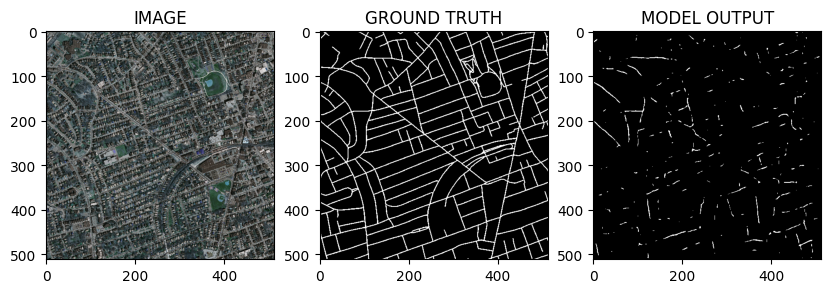

In [68]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

